## Predicting Compliance with Property Maintenance Fines

This challenge is meant to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. For this project, the task is to predict whether a given blight ticket will be paid on time.

Two data files were provided in this project for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
Note: misspelled addresses may be incorrectly geolocated.


**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    c - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

The project's evaluation is based on predictions of the probabilities that each ticket from `test.csv` will be paid. The evaluation metric for this project is the Area Under the ROC Curve (AUC). The grade is based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 receives a passing grade, and over 0.75 recieves full points.

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.preprocessing as prep
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV

In [103]:
## Import Data ##
df_train = pd.read_csv("/Users/tal/Dropbox/Data_Science/UMich Python/Course 3/Final Project/train.csv",
                       encoding = 'ISO-8859-1')
df_test = pd.read_csv("/Users/tal/Dropbox/Data_Science/UMich Python/Course 3/Final Project/test.csv",
                       encoding = 'ISO-8859-1')
df_addresses = pd.read_csv("/Users/tal/Dropbox/Data_Science/UMich Python/Course 3/Final Project/addresses.csv",
                       encoding = 'ISO-8859-1')
df_latlon = pd.read_csv("/Users/tal/Dropbox/Data_Science/UMich Python/Course 3/Final Project/latlons.csv",
                       encoding = 'ISO-8859-1')

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (11,12,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [104]:
## Prepare initial train and test dataframes ##
df_addresses = df_addresses.merge(df_latlon, how = 'outer', on = 'address')
df_train = df_train.merge(df_addresses, how = 'inner', on = 'ticket_id')
df_train = df_train[~pd.isnull(df_train['compliance'])]
df_train = df_train.set_index('ticket_id')

df_test = df_test.merge(df_addresses, how = 'inner', on = 'ticket_id')
df_test = df_test.set_index('ticket_id')

y = df_train['compliance']

## Data exploration and preliminary feature selection

In [4]:
y.count(), np.mean(y)

(159880, 0.07253565173880411)

In [204]:
df_train.dtypes

agency_name                    object
inspector_name                 object
violator_name                  object
violation_street_number       float64
violation_street_name          object
violation_zip_code            float64
mailing_address_str_number    float64
mailing_address_str_name       object
city                           object
state                          object
zip_code                       object
non_us_str_code                object
country                        object
ticket_issued_date             object
hearing_date                   object
violation_code                 object
violation_description          object
disposition                    object
fine_amount                   float64
admin_fee                     float64
state_fee                     float64
late_fee                      float64
discount_amount               float64
clean_up_cost                 float64
judgment_amount               float64
payment_amount                float64
balance_due 

In [205]:
df_train.head() 

,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,...,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon,fee_test
ticket_id,,,,,,,,,,,,,,,,,,,,,
22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268,25.0
27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,MI,...,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"4311 central, Detroit MI",42.326937,-83.135118,75.0
22046,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","KASIMU, UKWELI",6478.0,NORTHFIELD,NaN,2755.0,E. 17TH,LOG BEACH,CA,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"6478 northfield, Detroit MI",42.145257,-83.208233,25.0
18738,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Deerwood Development Group Inc, Deer",8027.0,BRENTWOOD,NaN,476.0,Garfield,Clinton,MI,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8027 brentwood, Detroit MI",42.433466,-83.023493,75.0
18735,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Rafee Auto Services L.L.C., RAF",8228.0,MT ELLIOTT,NaN,8228.0,Mt. Elliott,Detroit,MI,...,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"8228 mt elliott, Detroit MI",42.388641,-83.037858,10.0


### Numeric features

In [213]:
## Descriptive statistics for numeric variables ##
desc_stat_num = df_train.describe()

# Add covariance, correlation coefficients with the target
cov = [None] * desc_stat_num.shape[1]
corrcoef = [None] * desc_stat_num.shape[1]
i = 0

for feature in list(desc_stat_num.columns):
    corrcoef[i] = np.corrcoef(df_train[feature], df_train['compliance'])[0][1]
    cov[i] = np.cov(df_train[feature], df_train['compliance'])[0][1]
    i += 1

corrcoef = pd.Series(data = corrcoef, index = desc_stat_num.columns, name = 'correlation coefficient')
cov = pd.Series(data = cov, index = desc_stat_num.columns, name = 'covariance')

desc_stat_num.append([cov, corrcoef])

/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,violation_street_number,violation_zip_code,mailing_address_str_number,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,compliance,lat,lon,fee_test
count,1.598800e+05,0.0,1.573220e+05,159880.000000,159880.0,159880.0,159880.000000,159880.000000,159880.0,159880.000000,159880.000000,159880.000000,159880.000000,159878.000000,159878.000000,159880.000000
mean,1.071316e+04,NaN,9.133714e+03,357.035295,20.0,10.0,33.651512,0.195959,0.0,420.650218,72.206537,348.263284,0.072536,42.389747,-83.111530,33.614922
std,3.623159e+04,NaN,3.657729e+04,675.655580,0.0,0.0,67.692916,4.290344,0.0,742.555062,259.849545,729.295700,0.259374,0.037120,0.093515,67.719199
min,0.000000e+00,NaN,1.000000e+00,0.000000,20.0,10.0,0.000000,0.000000,0.0,0.000000,0.000000,-7750.000000,0.000000,42.145257,-84.403766,-30.000000
25%,4.920000e+03,NaN,5.320000e+02,200.000000,20.0,10.0,10.000000,0.000000,0.0,250.000000,0.000000,85.000000,0.000000,42.364536,-83.185854,10.000000
50%,1.039800e+04,NaN,2.418000e+03,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,42.392575,-83.124521,25.000000
75%,1.578325e+04,NaN,1.284400e+04,250.000000,20.0,10.0,25.000000,0.000000,0.0,305.000000,0.000000,305.000000,0.000000,42.419160,-83.033202,25.000000
max,1.415411e+07,NaN,5.111345e+06,10000.000000,20.0,10.0,1000.000000,350.000000,0.0,11030.000000,11030.000000,11030.000000,1.000000,44.785389,-82.512936,1000.000000
covariance,-2.373488e+01,NaN,NaN,-8.610620,0.0,0.0,-1.493379,0.173678,0.0,-10.137935,14.377270,-24.674469,0.067275,NaN,NaN,-1.527315
correlation coefficient,-2.525654e-03,NaN,NaN,-0.049134,NaN,NaN,-0.085055,0.156073,NaN,-0.052637,0.213319,-0.130442,1.000000,NaN,NaN,-0.086954


I'm eliminating features that either 1) have no values; 2) don't appear in the test set; 3) are constant; 4) are street numbers; or 5) 'judgment_amount', which is the sum of all the fines and fees given by the other variables, and therefore redundant. 

** - The selected numerical features are: 'fine_amount', 'late_fee', 'discount_amount', 'lat', and 'lon'. **

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12356b518>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1236e3518>]], dtype=object)

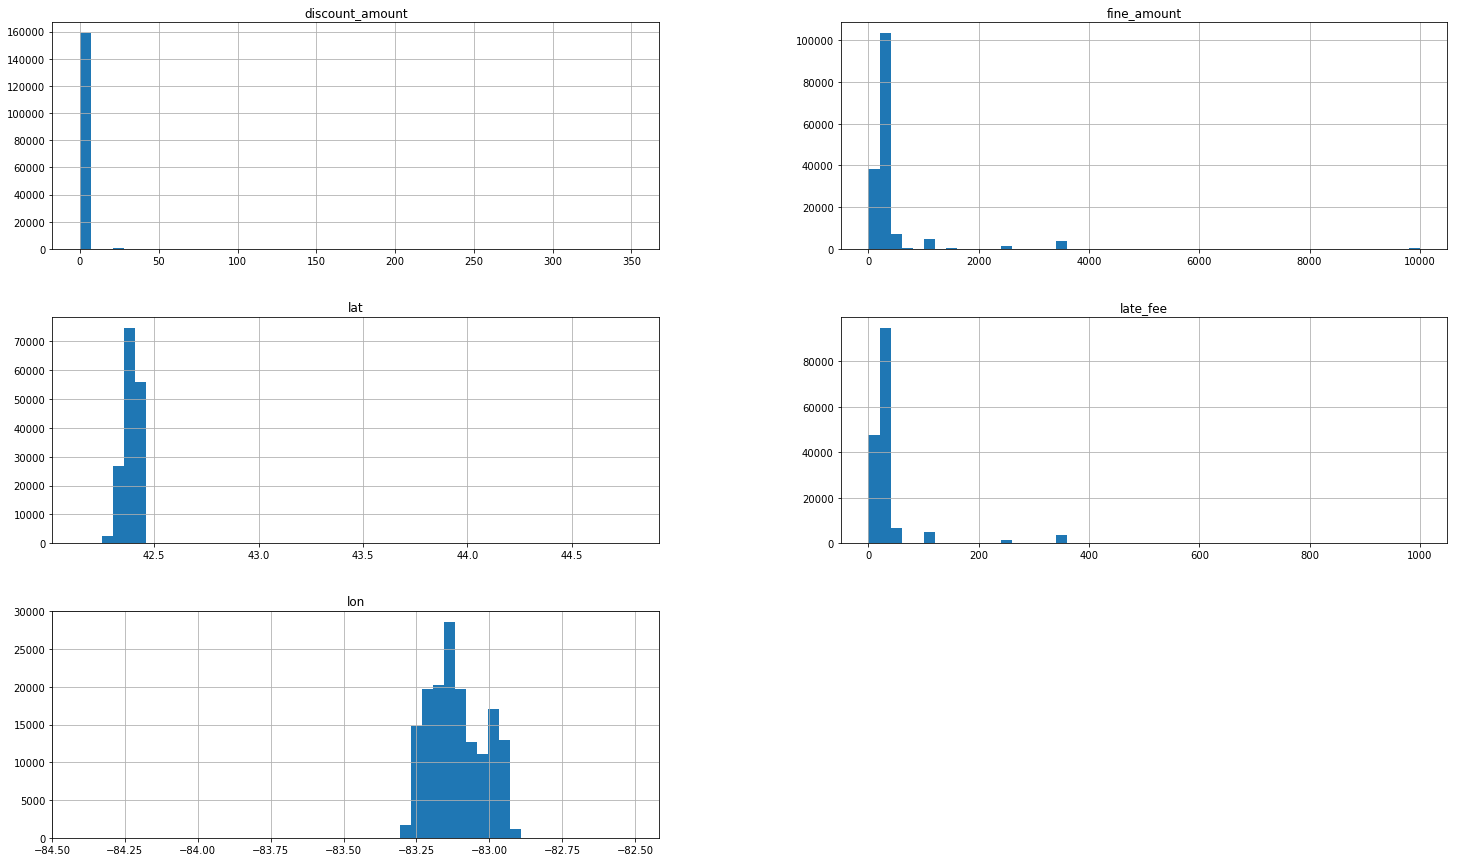

In [241]:
%matplotlib inline
df_train[['fine_amount', 'late_fee', 'discount_amount', 'lat', 'lon']].hist(bins = 50, figsize = (25,15)) 

### Categorical features

In [189]:
## Descriptive statistics for categorical variables

categorical_vars = ['agency_name', 'inspector_name', 'violator_name', 'violation_street_name', 
                    'mailing_address_str_name', 'city', 'state', 'zip_code', 'non_us_str_code', 'country', 
                    'violation_code', 'violation_description', 'disposition'] 
df_train[categorical_vars].describe()

,agency_name,inspector_name,violator_name,violation_street_name,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,violation_code,violation_description,disposition
count,159880,159880,159854,159880,159877,159880,159796,159879,3,159880,159880,159880,159880
unique,5,159,84656,1716,28440,4093,59,4622,2,5,189,207,4
top,"Buildings, Safety Engineering & Env Department","Morris, John","INVESTMENT, ACORN",SEVEN MILE,PO BOX,DETROIT,MI,48221,"ONTARIO, Canada",USA,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default
freq,95863,11604,624,2373,5754,87426,143655,4524,2,159869,64414,64414,138340


First, I'm eliminating categorical features that have either 1) over 1,000 unique values; 2) too little variation ('country'); or 3) too many missing values ('non_us_str_code').

Remainning features: 'agency_name', 'inspector_name', 'state', 'violation_code', 'violation_description', 
                    'disposition'.   

In [211]:
def explore_categorical_feature(var):
    # This function performs a deeper exploration of the categorical features
    cat_explore = pd.concat([df_train[var].value_counts(), 
                        df_train.groupby(var)['compliance'].mean(), 
                        df_train.groupby(var)['compliance'].sem()], axis = 1, 
                        keys = ['Train Count', 'Positive Rate', 'SEM'])
    cat_explore.index.name = var
    cat_explore['Test Count'] = cat_explore.index
    cat_explore['Test Count'] = cat_explore['Test Count'].apply(lambda x: df_test[df_test[var] == x].count()[0])
    cat_explore.sort_values('Train Count', ascending = False, inplace = True)
    return cat_explore.iloc[0:8, :]

In [212]:
explore_categorical_feature('agency_name')

,Train Count,Positive Rate,SEM,Test Count
agency_name,,,,
"Buildings, Safety Engineering & Env Department",95863,0.060743,0.000771,16832
Department of Public Works,52445,0.089961,0.001249,40731
Health Department,7107,0.065851,0.002942,0
Detroit Police Department,4464,0.131720,0.005062,3438
Neighborhood City Halls,1,0.000000,NaN,0


In [184]:
explore_categorical_feature('inspector_name')

,Train Count,Positive Rate,SEM,Test Count
inspector_name,,,,
"Morris, John",11604,0.039211,0.001802,0
"Samaan, Neil J",8720,0.073394,0.002793,0
"O'Neal, Claude",8075,0.067492,0.002792,197
"Steele, Jonathan",6962,0.047975,0.002562,0
"Devaney, John",6837,0.057920,0.002825,0
"Hayes, Billy J",6385,0.076899,0.003335,0
"Sloane, Bennie J",5624,0.061878,0.003213,0
"Sims, Martinzie",5526,0.040717,0.002659,0


I'm eliminating 'inspector_name' because it is inconsistent between the training and test sets. 

In [185]:
explore_categorical_feature('state')

,Train Count,Positive Rate,SEM,Test Count
state,,,,
MI,143655,0.073753,0.000690,51866
CA,3828,0.047544,0.003440,1877
TX,1952,0.046107,0.004748,913
FL,1680,0.063095,0.005934,863
SC,1066,0.020638,0.004356,350
IL,896,0.119420,0.010840,275
OH,639,0.123631,0.013032,241
NY,535,0.080374,0.011765,802


In [186]:
explore_categorical_feature('violation_code')

,Train Count,Positive Rate,SEM,Test Count
violation_code,,,,
9-1-36(a),64414,0.074006,0.001031,8653
9-1-81(a),23145,0.032059,0.001158,1604
22-2-88,19073,0.070886,0.001858,19
9-1-104,16927,0.082235,0.002112,16259
22-2-88(b),4879,0.063128,0.003482,15699
22-2-45,4200,0.131905,0.005222,2844
9-1-105,3619,0.088699,0.004727,140
9-1-110(a),3147,0.122974,0.005855,2005


In [187]:
explore_categorical_feature('violation_description')

,Train Count,Positive Rate,SEM,Test Count
violation_description,,,,
Failure of owner to obtain certificate of compliance,64414,0.074006,0.001031,8653
Failure to obtain certificate of registration for rental property,23145,0.032059,0.001158,1604
"Failure of owner to keep property, its sidewalks, or adjoining public property free from solid waste",19072,0.070889,0.001858,16
Excessive weeds or plant growth one- or two-family dwelling or commercial Building,16927,0.082235,0.002112,16259
Allowing bulk solid waste to lie or accumulate on or about the premises,4879,0.063128,0.003482,15699
Violation of time limit for approved containers to remain at curbside - early or late,4200,0.131905,0.005222,2844
Rodent harborage one-or two-family dwelling or commercial building,3619,0.088699,0.004727,140
Inoperable motor vehicle(s) one- or two-family dwelling or commercial building,3147,0.122974,0.005855,2005


I am eliminating 'violation_description' because it is redundant with 'violation_code'.

In [210]:
explore_categorical_feature('disposition')

,Train Count,Positive Rate,SEM,Test Count
disposition,,,,
Responsible by Default,138340,0.038203,0.000515,51602
Responsible by Admission,13701,0.275016,0.003815,4484
Responsible by Determination,7644,0.307300,0.005277,4124
Responsible (Fine Waived) by Deter,195,1.000000,0.000000,781


** - The selected categorical features are 'agency_name', 'inspector_name', 'state', 'violation_code', and 'disposition'. **

## Feature preprocessing

In [260]:
# Concatenate training and test set for consistent preprocessing
df_joint = pd.concat([df_train, df_test], copy = False)

# Select features
df_joint = df_joint[['agency_name', 'state', 'violation_code', 'disposition', 'fine_amount', 'late_fee', 
                     'discount_amount', 'lat', 'lon']]

In [261]:
def set_rare_cat_to_zero(column, min_count = 100):
    # This function changes to "other" categories with fewer occurrences than a given value.
    vc = column.value_counts()
    values_to_keep = vc[vc > min_count].index
    return column.apply (lambda x: x if x in values_to_keep else "other")  

In [262]:
# Reduce the number of categorical values
categorical_vars = ['agency_name', 'state', 'violation_code', 'disposition']
for var in categorical_vars: set_rare_cat_to_zero(df_joint[var])

In [263]:
df_joint[categorical_vars].describe()

,agency_name,state,violation_code,disposition
count,220881,220466,220881,220881
unique,5,59,223,8
top,"Buildings, Safety Engineering & Env Department",MI,9-1-36(a),Responsible by Default
freq,112695,195521,73067,189942


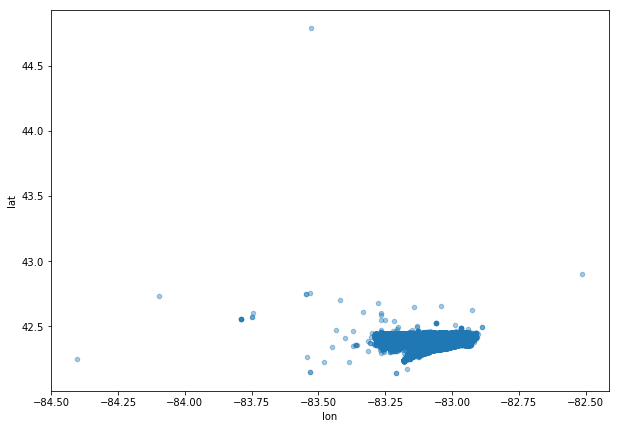

In [265]:
df_joint.plot(kind = 'scatter', x = 'lon', y = 'lat', alpha = .4, figsize = (10, 7))

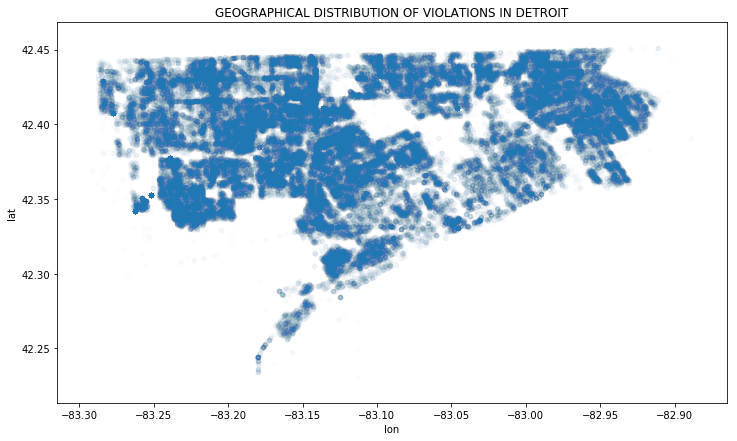

In [277]:
# As the prompt for the final project indicates, there appears to be a small number of incorrect values that are outside 
# the city limits. Here, I set values that are clearly outside the city limits to the mean.

mean_lat = df_joint['lat'].mean()
mean_lon = df_joint['lon'].mean()

df_joint['lat'] = df_joint['lat'].apply(lambda x: x if (x > 42.23) and (x < 42.451) else mean_lat)  
df_joint['lon'] = df_joint['lon'].apply(lambda x: x if (x < -82.88) and (x > -83.3) else mean_lon)  

# Visualize the corrected geographical data
df_joint.plot(kind = 'scatter', x = 'lon', y = 'lat', alpha = .01, figsize = (12, 7), 
              title = "GEOGRAPHICAL DISTRIBUTION OF VIOLATIONS IN DETROIT")

In [268]:
# Add polynomial features to geographical data
poly = prep.PolynomialFeatures(3)
lonlat_poly = poly.fit_transform(df_joint[['lat', 'lon']])
poly_names = poly.get_feature_names(input_features=['lat', 'lon'])
for i in range (3,10):
    df_joint[poly_names[i]] = lonlat_poly[:,i]

In [365]:
# Convert categorical features into dummy variables 
df_joint_dum = pd.get_dummies(df_joint, drop_first = True, sparse = True)

In [315]:
# Scale features
numerical_vars = list(df_joint_dum.columns[0:12])
scaler = prep.MinMaxScaler(feature_range = (0, 1))
df_joint_dum[numerical_vars] = scaler.fit_transform(df_joint_dum[numerical_vars])

In [316]:
# Re-split dataframe into training and test sets
df_train_processed = df_joint_dum.merge(pd.DataFrame(df_train.index), how = 'inner', right_on = 'ticket_id', 
                                        left_index = True)
df_test_processed = df_joint_dum.merge(pd.DataFrame(df_test.index), how = 'inner', right_on = 'ticket_id', 
                                       left_index = True)
df_train_processed = df_train_processed.set_index('ticket_id')
df_test_processed = df_test_processed.set_index('ticket_id')

In [409]:
# Splitting the data to training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df_train_processed, y, test_size = 0.25, random_state = 0)

## Model selection

### Logistic Regression

In [410]:
# Tune linear regression classifier with all features. Previous experiments that class_weight = "balanced" and
# penalty = 'l2' had the best performance.

log_reg = LogisticRegression(class_weight = 'balanced', penalty = 'l2', random_state = 0)

# Tune regularization strength
grid_values = {'C': [0.01, 0.1, 1, 10, 100] }
grid_log_reg = GridSearchCV(log_reg, param_grid = grid_values, scoring = 'roc_auc')
grid_log_reg.fit(X_train, y_train)
pd.DataFrame(grid_log_reg.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,7.823357,0.209200,0.800806,0.807361,10,{'C': 10},1,0.799328,0.808489,0.801747,0.805878,0.801344,0.807717,0.539167,0.020848,0.001058,0.001095
4,12.092612,0.199868,0.800709,0.808365,100,{'C': 100},2,0.799807,0.809452,0.801060,0.806974,0.801259,0.808669,1.176269,0.028785,0.000643,0.001034
2,4.830732,0.227709,0.796993,0.802148,1,{'C': 1},3,0.795349,0.802965,0.799119,0.800751,0.796511,0.802727,0.143245,0.003635,0.001576,0.000992
1,2.898409,0.227640,0.790457,0.794203,0.1,{'C': 0.1},4,0.789541,0.795120,0.792768,0.792655,0.789062,0.794833,0.211618,0.005952,0.001646,0.001101
0,2.254150,0.233016,0.781784,0.783929,0.01,{'C': 0.01},5,0.780070,0.784622,0.784752,0.782582,0.780531,0.784582,0.250376,0.006627,0.002107,0.000952


In [411]:
## Select features with RFECV ##
log_reg = grid_log_reg.best_estimator_
selector = RFECV(log_reg, step = .1, cv = 3, scoring = 'roc_auc')
selector = selector.fit(X_train, y_train)

# Create dataset with the selected features
X_log_reg_selected_features =  X_train.loc[:, selector.support_]
X_log_reg_selected_features.head()

,fine_amount,late_fee,discount_amount,lat,lat^3,lat lon^2,lon^3,agency_name_Neighborhood City Halls,state_AZ,state_BC,...,violation_code_9-1-503,violation_code_9-1-81(b),violation_code_9-1-81(e),violation_code_9-1-82(b),violation_code_9-1-82(d) - (Buildin,violation_code_9-1-82(d) - (Dwellin,violation_code_9-1-83 - (Structures,disposition_Responsible (Fine Waived) by Deter,disposition_Responsible by Admission,disposition_Responsible by Default
ticket_id,,,,,,,,,,,,,,,,,,,,,
22056,0.025,0.025,0.0,0.726854,0.725823,0.524108,0.416100,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27586,0.075,0.075,0.0,0.436632,0.435355,0.408875,0.389100,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22046,0.025,0.025,0.0,0.726002,0.724969,0.710903,0.206975,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18738,0.075,0.075,0.0,0.921287,0.920911,0.392823,0.666536,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18735,0.010,0.010,0.0,0.717357,0.716304,0.327097,0.630875,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [445]:
# AUC Scoring the selected model using the validation set
log_reg = selector.estimator_
y_score = log_reg.decision_function(X_val.loc[:, selector.support_])
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_val, y_score)
auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
print ('AUC for linear regression model is', auc_log_reg)

AUC for linear regression model is 0.796874651449


### Random Forest

In [416]:
# Tune Random Forest Classifier with all features
RFC = RandomForestClassifier(n_estimators = 100, random_state = 0, n_jobs = -1)
grid_values = {'max_depth': [6, 12, 24], 'max_features': [9, 18, 36, 72]}
grid_RFC = GridSearchCV(RFC, param_grid = grid_values, scoring = 'roc_auc')
grid_RFC.fit(X_train, y_train)
pd.DataFrame(grid_RFC.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,13.668605,0.663096,0.819680,0.948726,24,18,"{'max_depth': 24, 'max_features': 18}",1,0.815781,0.954230,0.821659,0.946663,0.821598,0.945285,0.418017,0.092304,0.002757,0.003932
10,21.516263,0.601163,0.817161,0.972395,24,36,"{'max_depth': 24, 'max_features': 36}",2,0.812208,0.974764,0.818381,0.971367,0.820895,0.971056,0.097677,0.066774,0.003650,0.001679
8,8.422704,0.603368,0.816980,0.914376,24,9,"{'max_depth': 24, 'max_features': 9}",3,0.812973,0.921160,0.820238,0.909215,0.817729,0.912752,0.231842,0.051160,0.003013,0.005010
6,12.916774,0.455610,0.816097,0.860606,12,36,"{'max_depth': 12, 'max_features': 36}",4,0.812228,0.865628,0.818484,0.856765,0.817579,0.859424,0.483133,0.015629,0.002761,0.003714
7,20.708012,0.456023,0.815830,0.865087,12,72,"{'max_depth': 12, 'max_features': 72}",5,0.811105,0.871064,0.818459,0.860610,0.817926,0.863586,0.485375,0.014022,0.003348,0.004398
5,7.439162,0.428460,0.813400,0.850255,12,18,"{'max_depth': 12, 'max_features': 18}",6,0.808720,0.851936,0.816967,0.849302,0.814512,0.849528,0.224076,0.046278,0.003458,0.001192
11,33.981795,0.569390,0.811826,0.982388,24,72,"{'max_depth': 24, 'max_features': 72}",7,0.806860,0.985348,0.813188,0.981858,0.815430,0.979959,0.251249,0.013102,0.003629,0.002232
3,12.230867,0.358136,0.808104,0.817303,6,72,"{'max_depth': 6, 'max_features': 72}",8,0.802884,0.819873,0.812114,0.816395,0.809313,0.815642,0.805212,0.004948,0.003864,0.001843
4,4.545348,0.447225,0.807399,0.837263,12,9,"{'max_depth': 12, 'max_features': 9}",9,0.803204,0.838024,0.810956,0.838256,0.808037,0.835509,0.170326,0.004911,0.003197,0.001244
2,6.596301,0.349240,0.807009,0.816614,6,36,"{'max_depth': 6, 'max_features': 36}",10,0.803858,0.820336,0.808897,0.813577,0.808271,0.815930,0.495542,0.021109,0.002242,0.002801


In [440]:
# Sorting features by their importance
RFC = grid_RFC.best_estimator_
feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(X_train.columns, RFC.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns = {0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending = False, inplace = True)
most_important_features = list(importances[importances['Gini-importance'] > 0.01].index)
importances

,Gini-importance
late_fee,0.181504
discount_amount,0.100822
disposition_Responsible by Default,0.086934
disposition_Responsible by Admission,0.066767
disposition_Responsible by Determination,0.054672
lat^2,0.044980
lon,0.044945
lat lon,0.044664
lat,0.044535
lat^2 lon,0.044482


In [446]:
# AUC Scoring the selected model using the validation set
RFC = grid_RFC.best_estimator_
y_score = RFC.predict_proba(X_val)
fpr_RFC, tpr_RFC, _ = roc_curve(y_val, y_score[:,1])
auc_RFC = auc(fpr_RFC, tpr_RFC)
print ('AUC for random forest model is', auc_RFC)

AUC for random forest model is 0.824972020779


### K Nearest Neighbours

In [442]:
# Tune KNN model
KNN = KNeighborsClassifier (n_jobs = -1)
grid_values = {'n_neighbors': [5, 20, 80, 240], 'weights': ['uniform', 'distance']}
grid_KNN = GridSearchCV(KNN, param_grid = grid_values, scoring = 'roc_auc')

# Leaving in only features with highest Gini importance
grid_KNN.fit(X_train[most_important_features], y_train)
pd.DataFrame(grid_KNN.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,param_weights,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,15.764231,12.001342,0.811829,0.999632,240,distance,"{'n_neighbors': 240, 'weights': 'distance'}",1,0.813133,0.999645,0.807561,0.999660,0.814793,0.999590,0.099173,0.379813,0.003093,0.000030
5,16.038710,6.825420,0.808845,0.999632,80,distance,"{'n_neighbors': 80, 'weights': 'distance'}",2,0.810158,0.999645,0.807414,0.999660,0.808963,0.999590,0.510187,0.183447,0.001124,0.000030
3,15.830943,4.119066,0.784981,0.999178,20,distance,"{'n_neighbors': 20, 'weights': 'distance'}",3,0.785446,0.999474,0.783697,0.999064,0.785802,0.998995,0.284374,0.079385,0.000920,0.000211
4,15.905521,6.973666,0.771874,0.823887,80,uniform,"{'n_neighbors': 80, 'weights': 'uniform'}",4,0.773016,0.825158,0.775918,0.821442,0.766686,0.825061,0.355017,0.383075,0.003855,0.001729
6,15.929142,12.240288,0.766532,0.791999,240,uniform,"{'n_neighbors': 240, 'weights': 'uniform'}",5,0.767653,0.792662,0.765839,0.790188,0.766105,0.793146,0.212385,0.325658,0.000800,0.001296
2,16.253415,4.194218,0.762900,0.880033,20,uniform,"{'n_neighbors': 20, 'weights': 'uniform'}",6,0.763073,0.881023,0.764228,0.878121,0.761401,0.880954,0.464644,0.123282,0.001160,0.001352
1,17.106627,3.011458,0.729561,0.997560,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",7,0.730596,0.998281,0.724149,0.997365,0.733939,0.997035,1.293064,0.008463,0.004063,0.000527
0,17.197995,3.374429,0.720512,0.947903,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",8,0.721479,0.947637,0.715474,0.948311,0.724584,0.947762,0.225274,0.285250,0.003781,0.000292


In [443]:
# AUC Scoring the selected model using the validation set
KNN = grid_KNN.best_estimator_
y_score = KNN.predict_proba(X_val[most_important_features])
fpr_KNN, tpr_KNN, _ = roc_curve(y_val, y_score[:,1])
auc_KNN = auc(fpr_KNN, tpr_KNN)
print ('AUC for K nearest neighbors model is', auc_KNN)

AUC for K nearest neighbors model is 0.822466821094


### Plot ROC Curve

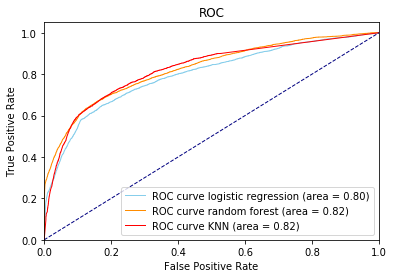

In [449]:
plt_roc = plt
plt_roc.figure()
lw = 1

plt_roc.plot(fpr_log_reg, tpr_log_reg, color = 'skyblue', lw = lw, 
             label = 'ROC curve logistic regression (area = %0.2f)' % auc_log_reg)
plt_roc.plot(fpr_RFC, tpr_RFC, color = 'darkorange', lw = lw, 
             label = 'ROC curve random forest (area = %0.2f)' % auc_RFC)
plt_roc.plot(fpr_KNN, tpr_KNN, color = 'red', lw = lw, label = 'ROC curve KNN (area = %0.2f)' % auc_KNN)
plt_roc.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt_roc.xlim([0.0, 1.0])
plt_roc.ylim([0.0, 1.05])
plt_roc.xlabel('False Positive Rate')
plt_roc.ylabel('True Positive Rate')
plt_roc.title('ROC Curve for Tested Models')
plt_roc.legend(loc="lower right")
plt_roc.show()

## Results
Here is the ranking of the tested models with their AUC scores:
1. **Random forest** - 0.825 (just barely ahead of KNN)
2. **KNN** - 0.822
3. **Logistic regression** - 0.797

I submitted the test set predictions from a random forest model for my final project and it scored an AUC of 0.811 (full grade is 0.75 or higher).